### running the server
 sudo docker run --privileged --gpus all --net=host -v /tmp/.X11-unix:/tmp/.X11-unix:rw carlasim/carla:0.9.12 /bin/bash ./CarlaUE4.sh -RenderOffScreen

In [1]:
import glob
import os
import sys

try:
    sys.path.append(glob.glob('PythonAPI/carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass

import carla
import random
import cv2
import skimage.measure as measure

#in synchronous mode, sensor data must be added to a queue
import queue

client = carla.Client('localhost', 2000)
client.set_timeout(11.0)

In [4]:
print(client.get_available_maps())


['/Game/Carla/Maps/Town10HD_Opt', '/Game/Carla/Maps/Town02', '/Game/Carla/Maps/Town01_Opt', '/Game/Carla/Maps/Town03_Opt', '/Game/Carla/Maps/Town03', '/Game/Carla/Maps/Town05', '/Game/Carla/Maps/Town02_Opt', '/Game/Carla/Maps/Town10HD', '/Game/Carla/Maps/Town01', '/Game/Carla/Maps/Town05_Opt', '/Game/Carla/Maps/Town04', '/Game/Carla/Maps/Town04_Opt']


In [5]:
world = client.load_world('Town03')
settings = world.get_settings()
settings.fixed_delta_seconds = 0.05 #must be less than 0.1, or else physics will be noisy
#must use fixed delta seconds and synchronous mode for python api controlled sim, or else 
#camera and sensor data may not match simulation properly and will be noisy 
settings.synchronous_mode = True 
world.apply_settings(settings)

3

In [6]:
## weather 
weather = carla.WeatherParameters(
    cloudiness=20.0,
    precipitation=20.0,
    sun_altitude_angle=110.0)

world.set_weather(weather)

In [7]:
blueprints = world.get_blueprint_library().filter('*')
for blueprint in random.sample(list(blueprints), 30):
    print(blueprint.id)
    for attr in blueprint:
       print('  - {}'.format(attr))


walker.pedestrian.0013
  - ActorAttribute(id=generation,type=int,value=1(const))
  - ActorAttribute(id=gender,type=str,value=male(const))
  - ActorAttribute(id=age,type=str,value=child(const))
  - ActorAttribute(id=is_invincible,type=bool,value=True)
  - ActorAttribute(id=speed,type=float,value=0)
  - ActorAttribute(id=role_name,type=str,value=pedestrian)
vehicle.diamondback.century
  - ActorAttribute(id=generation,type=int,value=1(const))
  - ActorAttribute(id=number_of_wheels,type=int,value=2(const))
  - ActorAttribute(id=sticky_control,type=bool,value=True)
  - ActorAttribute(id=driver_id,type=int,value=4)
  - ActorAttribute(id=object_type,type=str,value=(const))
  - ActorAttribute(id=color,type=Color,value=Color(255,160,145,255))
  - ActorAttribute(id=role_name,type=str,value=autopilot)
walker.pedestrian.0010
  - ActorAttribute(id=generation,type=int,value=1(const))
  - ActorAttribute(id=gender,type=str,value=female(const))
  - ActorAttribute(id=age,type=str,value=child(const))
  -

In [8]:
actor_list = []

In [9]:
blueprint_library = world.get_blueprint_library()
bp = random.choice(blueprint_library.filter('vehicle')) # lets choose a vehicle at random

# lets choose a random spawn point
transform = random.choice(world.get_map().get_spawn_points()) 

#spawn a vehicle
vehicle = world.spawn_actor(bp, transform) 
actor_list.append(vehicle)

vehicle.set_autopilot(True)

In [10]:
m= world.get_map()
waypoint = m.get_waypoint(transform.location)

#lets add more vehicles
for _ in range(0, 200):
    transform = random.choice(m.get_spawn_points())

    bp_vehicle = random.choice(blueprint_library.filter('vehicle'))

    # This time we are using try_spawn_actor. If the spot is already
    # occupied by another object, the function will return None.
    other_vehicle = world.try_spawn_actor(bp_vehicle, transform)
    if other_vehicle is not None:
        #print(npc)
        other_vehicle.set_autopilot(True)
        actor_list.append(other_vehicle)

In [12]:
blueprint_library = world.get_blueprint_library()
weirdobj_bp = blueprint_library.find('static.prop.fountain')
weirdobj_transform = random.choice(world.get_map().get_spawn_points())
weirdobj_transform = carla.Transform(carla.Location(x=230, y=195, z=40), carla.Rotation(yaw=180))
weird_obj = world.try_spawn_actor(weirdobj_bp, weirdobj_transform)
actor_list.append(weird_obj)

In [13]:
#example for getting camera image
camera_bp = blueprint_library.find('sensor.camera.rgb')
camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
camera = world.spawn_actor(camera_bp, camera_transform, attach_to=vehicle)
image_queue = queue.Queue()
camera.listen(image_queue.put)
actor_list.append(camera)

# #example for getting depth camera image
# camera_depth = blueprint_library.find('sensor.camera.depth')
# camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
# camera_d = world.spawn_actor(camera_depth, camera_transform, attach_to=vehicle)
# image_queue_depth = queue.Queue()
# camera_d.listen(image_queue_depth.put)
# actor_list.append(camera_d)

# #example for getting semantic segmentation camera image
# camera_semseg = blueprint_library.find('sensor.camera.semantic_segmentation')
# camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
# camera_seg = world.spawn_actor(camera_semseg, camera_transform, attach_to=vehicle)
# image_queue_seg = queue.Queue()
# camera_seg.listen(image_queue_seg.put)
# actor_list.append(camera_seg)

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
# import pycocotools
import math
from scipy.spatial import distance

def get_mask(seg_im, rgb_value):
    # rgb_value should be somethiing like np.uint8([[[70, 70, 70]]])
    # seg_im should be in HSV
    
    hsv_value = cv2.cvtColor(rgb_value, cv2.COLOR_RGB2HSV)
    
    hsv_low = np.array([[[hsv_value[0][0][0]-5, hsv_value[0][0][1], hsv_value[0][0][2]-5]]])
    hsv_high = np.array([[[hsv_value[0][0][0]+5, hsv_value[0][0][1], hsv_value[0][0][2]+5]]])
    
    mask = cv2.inRange(seg_im, hsv_low, hsv_high)
    return mask

def get_bbox_from_mask(mask):
    label_mask = measure.label(mask)
    props = measure.regionprops(label_mask)
    
    return [prop.bbox for prop in props]
    
    
def get_camera_bbox_from_global(carlaLocObj, carlaTransformCamera):
    # takes in carla locations of object and camera and returns the bbox in camera frame. 
    # returns -1,-1,-1,-1 if outside box
    obj_x, obj_y, obj_z = carlaLocObj.x, carlaLocObj.y, carlaLocObj.z 
    
    cam_x, cam_y, cam_z = carlaTransformCamera.location.x, carlaTransformCamera.location.y, carlaTransformCamera.location.z
    
    pitch, yaw, roll = carlaTransformCamera.rotation.pitch, carlaTransformCamera.rotation.yaw, carlaTransformCamera.rotation.roll
    
    #adjust for pitch, yaw, roll. 
    y_corr = obj_y*math.cos(pitch)
    z_corr = obj_z*math.cos(yaw)
    x_corr = obj_z*math.cos(roll)
    
    
    #calculating the center y coord in image frame
    d_cm = distance.euclidean([cam_x, cam_y], [obj_x, obj_y])
    
    d_me = d_cm/math.tan(45)
    
    d_co = distance.euclidean([cam_x, cam_y, cam_z], [obj_x, obj_y, obj_z])
    
    d_om = np.sqrt(d_co**2 - d_cm**2)
    
    d_oe = d_me - d_om
    
    img_y = 800 - d_oe
    
    
    #calculating the center x coord in image frame
    d_cm = np.sqrt((obj_y - cam_y)**2)
    
    d_me = d_cm/(math.tan(45))
    
    d_om = np.sqrt(d_co**2 - d_om**2)
    
    img_x = d_me - d_om
    
    return img_x, img_y    

In [16]:
## get location of weird obj
world.tick()

6

In [17]:
#rgb camera
image = image_queue.get()

#semantic segmentation camera
# image_seg  = image_queue_seg.get()

#depth camera
# image_depth = image_queue_depth.get()

In [18]:
image.save_to_disk("test_images/%06d.png" %(image.frame))
# image_seg.save_to_disk("test_images/%06d_semseg.png" %(image.frame), carla.ColorConverter.CityScapesPalette)
# image_depth.save_to_disk("test_images/%06d_depth.png" %(image.frame), carla.ColorConverter.LogarithmicDepth)

'test_images/000006.png'

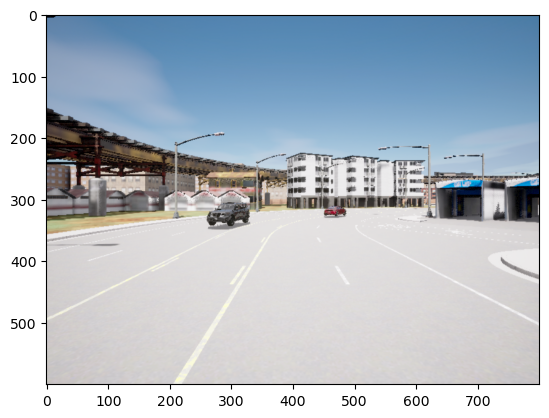

In [19]:
img = mpimg.imread("test_images/%06d.png" % image.frame)
# img_semseg = mpimg.imread("test_images/%06d_semseg.png" % image.frame)
# img_depth = mpimg.imread("test_images/%06d_depth.png" % image.frame)

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,18))
plt.imshow(img)
# ax2.imshow(img_semseg)
# ax3.imshow(img_depth) 
plt.show()


In [20]:
waypoint = random.choice(waypoint.next(1.5))
vehicle.set_transform(waypoint.transform)

In [21]:
#bgr value exmaples of few objects: full list at https://carla.readthedocs.io/en/0.9.9/ref_sensors/ 
object_list = dict()
object_list['building'] = np.uint8([[[70, 70, 70]]])        
object_list['pedestrian'] = np.uint8([[[220, 20, 60]]])
object_list['vegetation'] = np.uint8([[[107, 142, 35]]])
object_list['car'] = np.uint8([[[ 0, 0, 142]]])
object_list['fence'] = np.uint8([[[ 190, 153, 153]]])
object_list['traffic_sign'] = np.uint8([[[220, 220, 0]]])
object_list['pole'] = np.uint8([[[153, 153, 153]]])
object_list['wall'] = np.uint8([[[102, 102, 156]]])

In [22]:
# getting weird object locations
weirdobj_loc = weird_obj.get_location()

# returns bbox in camera frame from global cordinates
x_c, y_c = get_camera_bbox_from_global(weirdobj_loc, camera.get_transform())

print(x_c, y_c)

-253.80715075385686 679.8582977371814


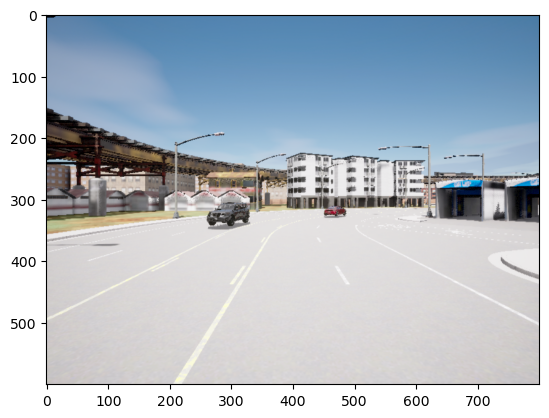

In [23]:
plt.imshow(img)

In [24]:
waypoint = random.choice(waypoint.next(1.5))
vehicle.set_transform(waypoint.transform)

In [33]:
timestamp = round(time.time())

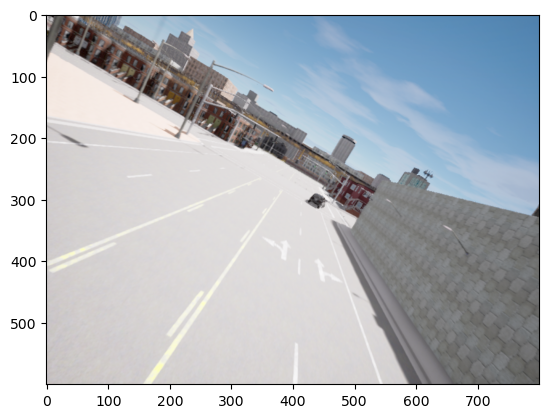

In [35]:
# from detectron2.structures import BoxMode
#in sychronous mode, client controls step of simulation and number of steps
dataset_dicts = []
global_count=0
for i in range(1000):
    #step
    world.tick()

    #rgb camera
    image = image_queue.get()

    #semantic segmentation camera
#     image_seg  = image_queue_seg.get()
    #image_seg.convert(carla.ColorConverter.CityScapesPalette)

    #depth camera
#     image_depth = image_queue_depth.get()
    #image_depth.convert(carla.ColorConverter.LogarithmicDepth)
    
    
    if i%100==0:
        image.save_to_disk(f"test_images/{timestamp}/%06d.png" %(image.frame))
#         image_seg.save_to_disk("test_images/%06d_semseg.png" %(image.frame), carla.ColorConverter.CityScapesPalette)
#         image_depth.save_to_disk("test_images/%06d_depth.png" %(image.frame), carla.ColorConverter.LogarithmicDepth)

        img = mpimg.imread(f"test_images/{timestamp}/%06d.png" %(image.frame))
#         img_semseg = mpimg.imread("test_images/%06d_semseg.png" % image.frame)
#         img_depth = mpimg.imread("test_images/%06d_depth.png" % image.frame)
        
        ## COCO format stuff, each image needs to have these keys
        height, width = cv2.imread(f"test_images/{timestamp}/%06d.png" %(image.frame)).shape[:2]
        record = {}
        record['file_name'] = f"test_images/{timestamp}/%06d.png" %(image.frame)
        global_count+=1
        record['image_id'] = global_count
        record['height'] = height
        record['width'] = width
        
        
        # fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (12,18))
        # ax1.imshow(img)
#         ax2.imshow(img_semseg)
#         ax3.imshow(img_depth) 
        plt.imshow(img)
        

    #drive vehicle to next waypoint on map
    waypoint = random.choice(waypoint.next(1.5))
    vehicle.set_transform(waypoint.transform)
        